In [1]:
#!pip install category_encoders
#Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from xgboost import XGBRegressor
from category_encoders import TargetEncoder
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("doordash.csv")

In [3]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2/6/2015 22:24,2/6/2015 23:27,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2/10/2015 21:49,2/10/2015 22:56,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,1/22/2015 20:39,1/22/2015 21:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2/3/2015 21:21,2/3/2015 22:13,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2/15/2015 2:40,2/15/2015 3:20,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [4]:
#If actual_delivery_time is missing, you can’t compute the delivery duration, making the row unusable for supervised learning.
critical_columns = [
    'market_id',
    'actual_delivery_time'
]

# Removing rows with null values in the above-mentioned attributes or columns
df = df.dropna(subset=critical_columns)

In [5]:
#  Convert timestamps and create target variable (delivery_duration in minutes)
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
df['delivery_duration'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds()/60

In [6]:
### Pre-Processing

# 1. Drop rows with critical missing values
df.dropna(subset=[
    'total_onshift_dashers', 'total_busy_dashers',
    'total_outstanding_orders', 'store_primary_category',
    'estimated_store_to_consumer_driving_duration', 'actual_delivery_time'
], inplace=True)

# 2. Target Encoding columns
te = TargetEncoder()
df['store_primary_category_encoded'] = te.fit_transform(df['store_primary_category'], df['delivery_duration'])
df['store_id'] = df['store_id'].astype(str)
df['store_id_encoded'] = te.fit_transform(df['store_id'], df['delivery_duration'])

# 3. One Hot Encoding columns
df = pd.get_dummies(df, columns=['market_id', 'order_protocol'], drop_first=True)

In [7]:
df.columns

Index(['created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'delivery_duration',
       'store_primary_category_encoded', 'store_id_encoded', 'market_id_2.0',
       'market_id_3.0', 'market_id_4.0', 'market_id_5.0', 'market_id_6.0',
       'order_protocol_2.0', 'order_protocol_3.0', 'order_protocol_4.0',
       'order_protocol_5.0', 'order_protocol_6.0', 'order_protocol_7.0'],
      dtype='object')

In [8]:
# STEP 4: Select Raw Numeric Features Only
# -----------------------------
numeric_columns = [
    'total_items', 'subtotal', 'num_distinct_items',
    'min_item_price', 'max_item_price',
    'estimated_order_place_duration',
    'estimated_store_to_consumer_driving_duration', 'total_onshift_dashers', 'total_busy_dashers',
    'total_outstanding_orders'
]

category_columns = ['store_primary_category_encoded', 'store_id_encoded', 'market_id_2.0',
       'market_id_3.0', 'market_id_4.0', 'market_id_5.0', 'market_id_6.0',
       'order_protocol_2.0', 'order_protocol_3.0', 'order_protocol_4.0',
       'order_protocol_5.0', 'order_protocol_6.0', 'order_protocol_7.0']

df_v1 = df[numeric_columns + category_columns + ['delivery_duration']].dropna()

In [9]:
# STEP 5: Define X and y
# -----------------------------
X = df_v1[numeric_columns + category_columns]
y = df_v1['delivery_duration']

In [10]:
#STEP 6: Train-Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------
# STEP 7: Define Models
# -----------------------------
models_v1 = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(),
    'Random Forest': RandomForestRegressor(n_estimators=30, max_depth=8, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=30, max_depth=4, learning_rate=0.1, random_state=42)
}

In [11]:
# STEP 8: Evaluation Function
# -----------------------------
def evaluate_model(y_true, y_pred):
    return {
        'MAE': round(mean_absolute_error(y_true, y_pred), 2),
        'RMSE': round(root_mean_squared_error(y_true, y_pred)),
        'R²': round(r2_score(y_true, y_pred), 4)
    }

In [12]:
# STEP 9: Train and Evaluate Each Model
# -----------------------------
results_v1 = {}
for name, model in models_v1.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results_v1[name] = evaluate_model(y_test, y_pred)

# -----------------------------
# STEP 10: View Results
# -----------------------------
import pprint
print("V2 Results (Null Value Removal):")
pprint.pprint(results_v1)

V2 Results (Null Value Removal):
{'Linear': {'MAE': 11.31, 'RMSE': 47, 'R²': 0.0633},
 'Random Forest': {'MAE': 11.64, 'RMSE': 47, 'R²': 0.0464},
 'Ridge': {'MAE': 11.31, 'RMSE': 47, 'R²': 0.0633},
 'XGBoost': {'MAE': 11.65, 'RMSE': 47, 'R²': 0.0446}}


In [13]:
df

,created_at,actual_delivery_time,store_id,store_primary_category,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,...,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,2015-02-06 22:24:00,2015-02-06 23:27:00,1845,american,4,3441,4,557,1239,33.0,...,False,False,False,False,False,False,False,False,False,False
1,2015-02-10 21:49:00,2015-02-10 22:56:00,5477,mexican,1,1900,1,1400,1400,1.0,...,False,False,False,False,True,False,False,False,False,False
8,2015-02-16 00:11:00,2015-02-16 00:38:00,5477,indian,4,4771,3,820,1604,8.0,...,False,False,False,False,False,True,False,False,False,False
14,2015-02-12 03:36:00,2015-02-12 04:14:00,2841,italian,1,1525,1,1525,1525,5.0,...,False,False,False,False,False,False,False,False,False,False
15,2015-01-27 02:12:00,2015-01-27 03:02:00,2841,italian,2,3620,2,1425,2195,5.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,2015-02-17 00:19:00,2015-02-17 01:24:00,2956,fast,3,1389,3,345,649,17.0,...,False,False,False,False,False,False,True,False,False,False
197424,2015-02-13 00:01:00,2015-02-13 00:58:00,2956,fast,6,3010,4,405,825,12.0,...,False,False,False,False,False,False,True,False,False,False
197425,2015-01-24 04:46:00,2015-01-24 05:36:00,2956,fast,5,1836,3,300,399,39.0,...,False,False,False,False,False,False,True,False,False,False
197426,2015-02-01 18:18:00,2015-02-01 19:23:00,3630,sandwich,1,1175,1,535,535,7.0,...,False,False,False,False,False,False,False,False,False,False


In [14]:
# Dropping Outliers to improve the model

def remove_outliers(df, outlier_columns):
    # Remove outliers based on IQR for each specified column
    for col in outlier_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# These are the actual numeric columns used in your model pipeline
outlier_columns = [
    'subtotal', 'delivery_duration', 'num_distinct_items', 'max_item_price', 'estimated_order_place_duration',
    'estimated_store_to_consumer_driving_duration'
]

# Drop outliers from the cleaned numeric dataset used in modeling
df_v1_cleaned = remove_outliers(df_v1.copy(), outlier_columns)

# Output size before and after
print(f"Original dataset size: {len(df_v1)}")
print(f"Cleaned dataset size: {len(df_v1_cleaned)}")

Original dataset size: 176005
Cleaned dataset size: 154959


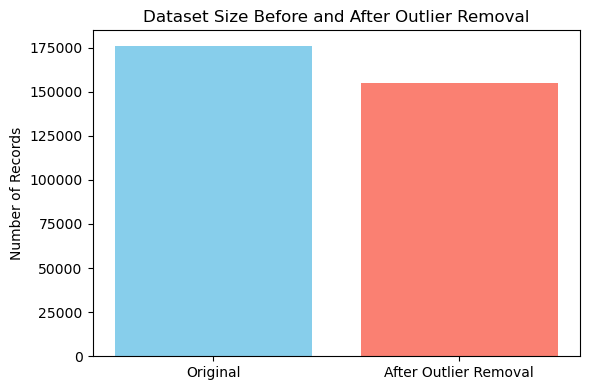

In [27]:
# Data
sizes = [len(df_v1), len(df_v1_cleaned)]
labels = ['Original', 'After Outlier Removal']

# Plot
plt.figure(figsize=(6, 4))
plt.bar(labels, sizes, color=['skyblue', 'salmon'])
plt.title("Dataset Size Before and After Outlier Removal")
plt.ylabel("Number of Records")
plt.tight_layout()
plt.show()

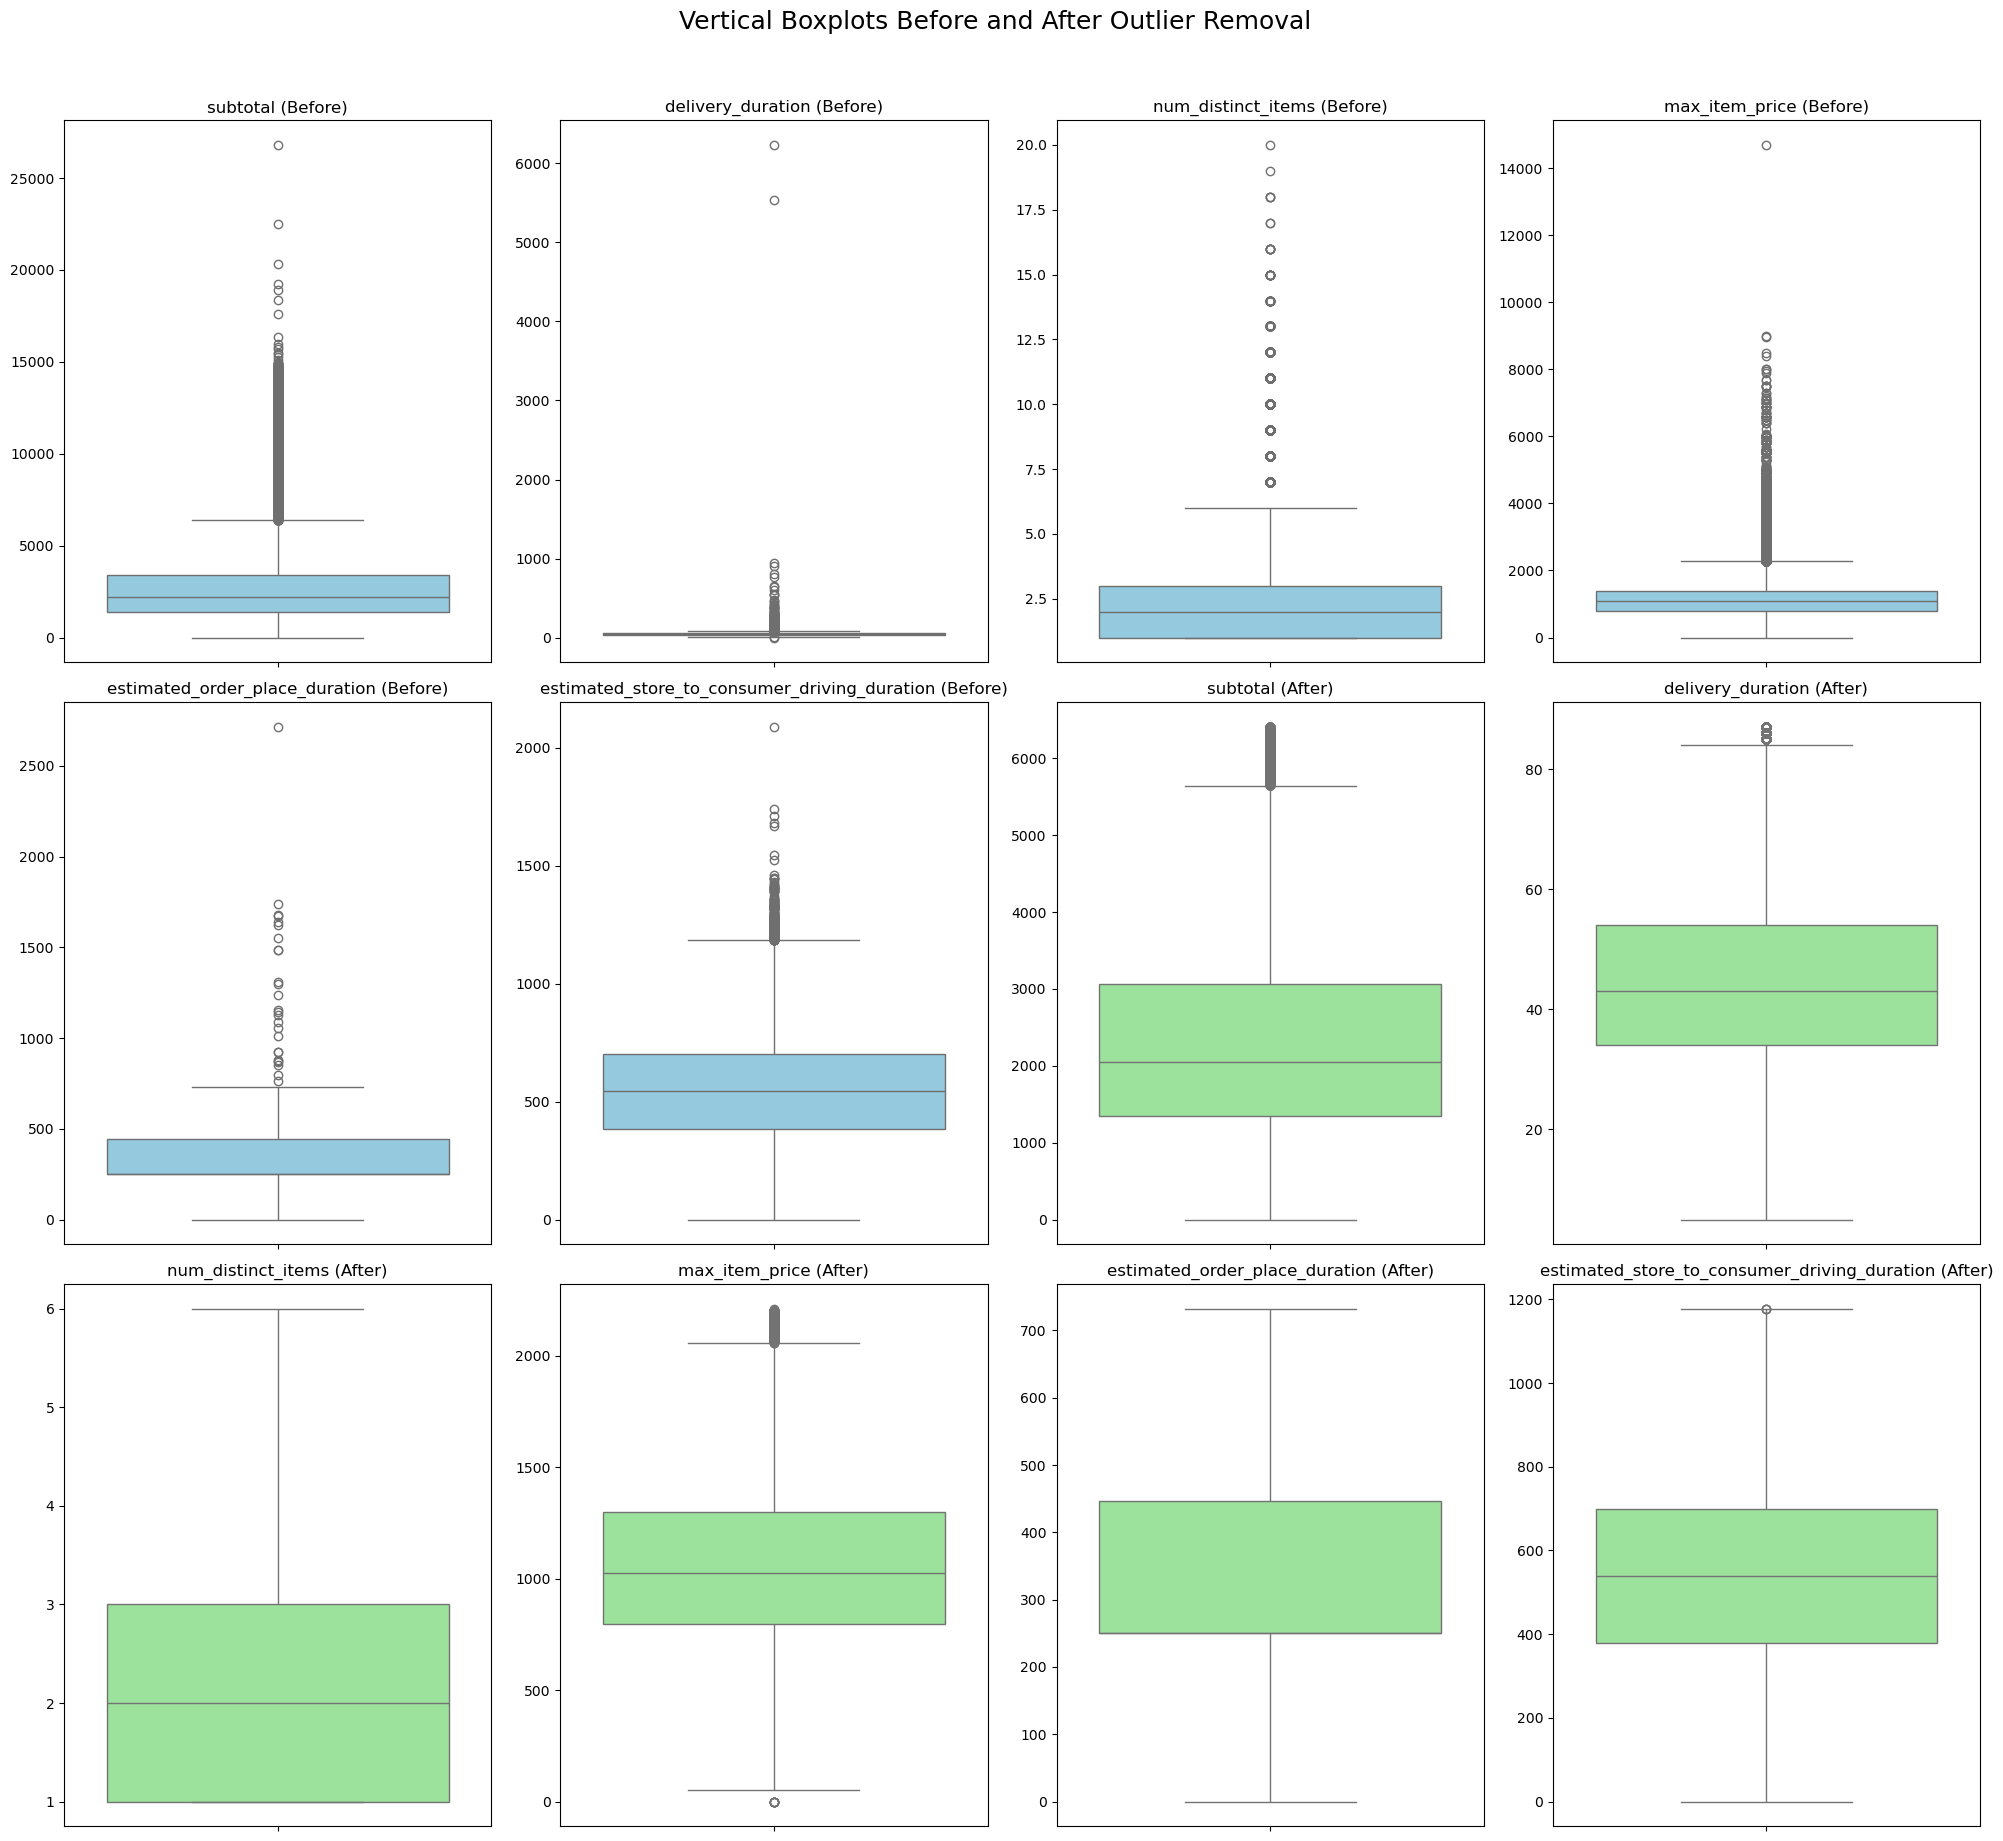

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Columns to visualize
boxplot_columns = [
'subtotal', 'delivery_duration', 'num_distinct_items', 'max_item_price', 'estimated_order_place_duration',
    'estimated_store_to_consumer_driving_duration'
]

# Total number of plots (before + after)
total_plots = len(boxplot_columns) * 2
n_cols = 4
n_rows = (total_plots + n_cols - 1) // n_cols  # Round up for rows

plt.figure(figsize=(5 * n_cols, 6 * n_rows))

for i, col in enumerate(boxplot_columns):
    # Before outlier removal
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(y=df_v1[col], color='skyblue')
    plt.title(f"{col} (Before)")
    plt.ylabel('')
    
    # After outlier removal
    plt.subplot(n_rows, n_cols, i + 1 + len(boxplot_columns))
    sns.boxplot(y=df_v1_cleaned[col], color='lightgreen')
    plt.title(f"{col} (After)")
    plt.ylabel('')

plt.suptitle("Vertical Boxplots Before and After Outlier Removal", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

In [15]:
features = [
    'total_items', 'subtotal', 'num_distinct_items',
    'min_item_price', 'max_item_price',
    'estimated_order_place_duration',
    'estimated_store_to_consumer_driving_duration', 'store_primary_category_encoded', 'store_id_encoded', 'market_id_2.0',
       'market_id_3.0', 'market_id_4.0', 'market_id_5.0', 'market_id_6.0',
       'order_protocol_2.0', 'order_protocol_3.0', 'order_protocol_4.0',
       'order_protocol_5.0', 'order_protocol_6.0', 'order_protocol_7.0'
]
# Step 2: Select X and y
X = df_v1_cleaned[features].copy()
y = df_v1_cleaned['delivery_duration']

# Step 4: Scale numerical columns
numeric_cols = [
    'total_items', 'subtotal', 'num_distinct_items',
    'min_item_price', 'max_item_price',
    'estimated_order_place_duration',
    'estimated_store_to_consumer_driving_duration'
]
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Step 5: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Initialize models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, tree_method='gpu_hist' if xgb.get_config().get('use_gpu') else 'auto')
}

# Step 7: Train, predict, evaluate
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'MAE': round(mean_absolute_error(y_test, y_pred), 2),
        'RMSE': round(np.sqrt(mean_squared_error(y_test, y_pred)), 2),
        'R²': round(r2_score(y_test, y_pred), 4)
    }

# Step 8: Display results
print("\nModel Performance Comparison:")
for name, metrics in results.items():
    print(f"{name}: {metrics}")


Model Performance Comparison:
LinearRegression: {'MAE': 10.26, 'RMSE': 12.92, 'R²': 0.2028}
Ridge: {'MAE': 10.26, 'RMSE': 12.92, 'R²': 0.2028}
Random Forest: {'MAE': 10.55, 'RMSE': 13.29, 'R²': 0.1561}
XGBoost: {'MAE': 10.21, 'RMSE': 12.85, 'R²': 0.2105}


In [20]:
xgb_best = models['XGBoost']
xgb_importance = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_best.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Show top 10
print("Top 10 Most Important Features (XGBoost):")
print(xgb_importance.head(10))

Top 10 Most Important Features (XGBoost):
                                         Feature  Importance
8                               store_id_encoded    0.381610
6   estimated_store_to_consumer_driving_duration    0.171761
1                                       subtotal    0.060114
2                             num_distinct_items    0.038790
16                            order_protocol_4.0    0.037250
5                 estimated_order_place_duration    0.033187
15                            order_protocol_3.0    0.028949
11                                 market_id_4.0    0.026885
18                            order_protocol_6.0    0.025193
9                                  market_id_2.0    0.024336


C:\Users\khach\AppData\Local\Temp\ipykernel_46524\1338076574.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=xgb_importance.head(10), x='Importance', y='Feature', palette='magma')


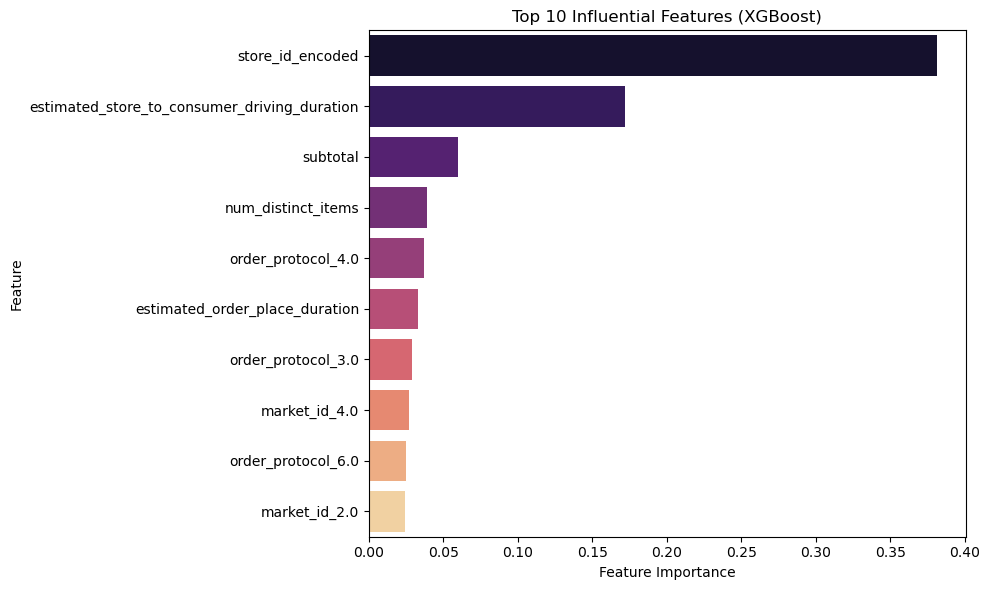

In [21]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=xgb_importance.head(10), x='Importance', y='Feature', palette='magma')
plt.title("Top 10 Influential Features (XGBoost)")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [22]:
# Your model results
results = {
    'LinearRegression': {'MAE': 10.26, 'RMSE': 12.92, 'R²': 0.2028},
    'Ridge': {'MAE': 10.26, 'RMSE': 12.92, 'R²': 0.2028},
    'Random Forest': {'MAE': 10.55, 'RMSE': 13.29, 'R²': 0.1561},
    'XGBoost': {'MAE': 10.21, 'RMSE': 12.85, 'R²': 0.2105}
}

results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'})

C:\Users\khach\AppData\Local\Temp\ipykernel_46524\1627011012.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='R²', palette='Blues_d')


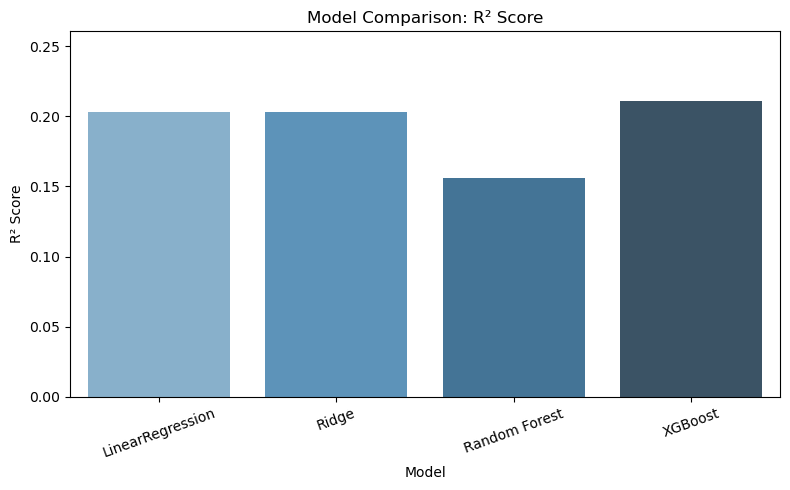

In [23]:
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='Model', y='R²', palette='Blues_d')
plt.title("Model Comparison: R² Score")
plt.ylim(0, max(results_df['R²']) + 0.05)
plt.ylabel("R² Score")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

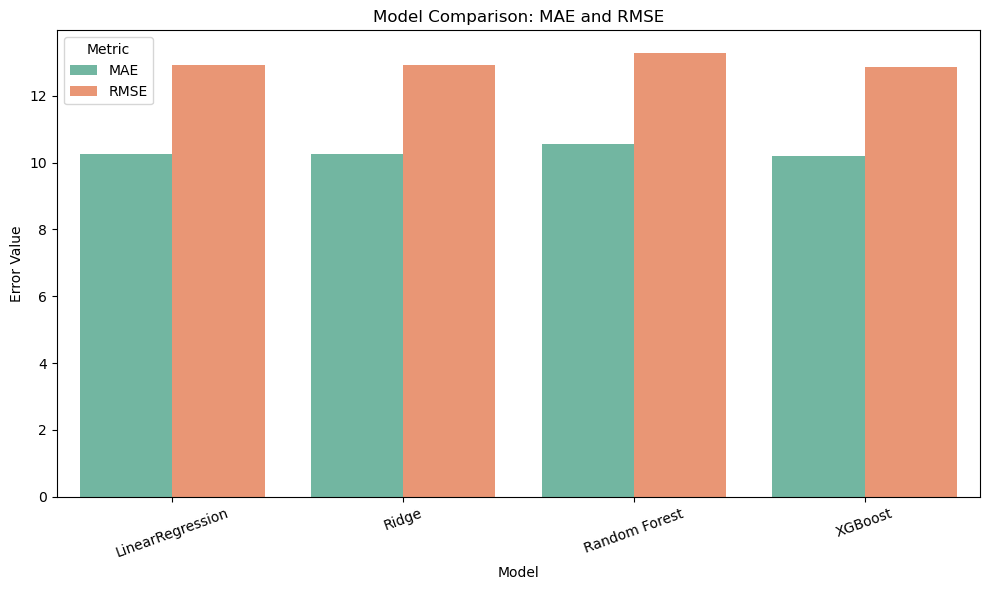

In [24]:
melted = results_df.melt(id_vars='Model', value_vars=['MAE', 'RMSE'], var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='Model', y='Value', hue='Metric', palette='Set2')
plt.title("Model Comparison: MAE and RMSE")
plt.ylabel("Error Value")
plt.xticks(rotation=20)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prepare features and target
X = df_v1_cleaned.drop('delivery_duration', axis=1)
y = df_v1_cleaned['delivery_duration']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Choose components explaining ~95% variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()
n_components_95 = (cumulative_variance < 0.95).sum() + 1

print(f"Using {n_components_95} components to explain ~95% of the variance.")

# Reduce data
X_reduced = X_pca[:, :n_components_95]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Results
print(f"Explained Variance (first {n_components_95} components): {pca.explained_variance_ratio_[:n_components_95]}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")

Using 17 components to explain ~95% of the variance.
Explained Variance (first 17 components): [0.15674417 0.10525804 0.09827649 0.06333956 0.05887707 0.05695177
 0.05179639 0.0482986  0.04515369 0.0436413  0.04330311 0.04234233
 0.04027536 0.03565503 0.03404382 0.02430479 0.01765537]
Mean Squared Error (MSE): 159.73
Root Mean Squared Error (RMSE): 12.64
Mean Absolute Error (MAE): 9.99
R² Score: 0.2368


In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prepare features and target
X = df_v1_cleaned.drop('delivery_duration', axis=1)
y = df_v1_cleaned['delivery_duration']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Choose components explaining ~95% variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()
n_components_95 = (cumulative_variance < 0.95).sum() + 1

print(f"Using {n_components_95} components to explain ~95% of the variance.")

# Reduce data
X_reduced = X_pca[:, :n_components_95]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

#  Train Ridge model
ridge_model = Ridge(alpha=1.0)  # you can tune alpha if needed
ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Results
print(f"PCA + Ridge Regression ")
print(f"Explained Variance (first {n_components_95} components): {pca.explained_variance_ratio_[:n_components_95]}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")

Using 17 components to explain ~95% of the variance.
PCA + Ridge Regression 
Explained Variance (first 17 components): [0.15674417 0.10525804 0.09827649 0.06333956 0.05887707 0.05695177
 0.05179639 0.0482986  0.04515369 0.0436413  0.04330311 0.04234233
 0.04027536 0.03565503 0.03404382 0.02430479 0.01765537]
Mean Squared Error (MSE): 159.73
Root Mean Squared Error (RMSE): 12.64
Mean Absolute Error (MAE): 9.99
R² Score: 0.2368


In [17]:
# Interpretation of Results: 

#1. We reduced your original features (probably 7–8 columns) down to 6 principal components — and those 6 synthetic features capture 95% of the structure and patterns in your original dataset.

#2. Each of those numbers shows how much individual importance each component carries.
#PC1 explains ~34.5% of the data's behavior.
#PC2 explains ~25.3%, and so on.
#Together, these 6 components cover ~95% of what drives variation in delivery times, prices, etc

#3. Mean Squared Error: The average of the squared differences between predicted and actual delivery durations

#4. Root Mean Squared Error: On average, your model is off by about 13.6 minutes per order.

# 5. Mean Absolute Error: This means that on average, your model’s predictions are off by 10.93 minutes — without squaring the errors.

#6. The R-squared score tells us how much variance in delivery time your model can explain.

In [ ]:
# Theory for slides: 
# The Intuition Behind 95% Variance in PCA
#Dimensionality Reduction:

#PCA reduces the number of features while preserving the most important patterns in the data.

#Choosing components that explain ~95% of the variance means you're retaining most of the information while dropping noise and redundancy.

#Bias-Variance Tradeoff:

#Keeping too many components: you keep noise → overfitting.

#Keeping too few: you lose signal → underfitting.

#95% is a sweet spot — enough to maintain predictive power but small enough to simplify the model.

#Model Efficiency:

#Fewer components = faster training and prediction.

#Especially useful when original data has multicollinearity or irrelevant features.

#📊 Example:
#Let’s say your data has 6 features:


#Component	Variance Explained
#PC1	45%
#PC2	25%
#PC3	15%
#PC4	10%
#PC5	3%
#PC6	2%
#Cumulative variance up to PC4 = 95%.

#So we keep PC1 to PC4, and drop PC5 & PC6 (they don’t add much).

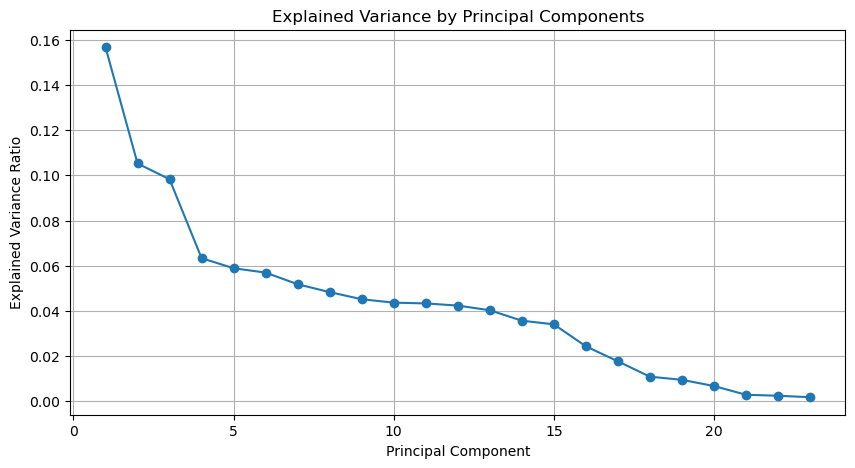

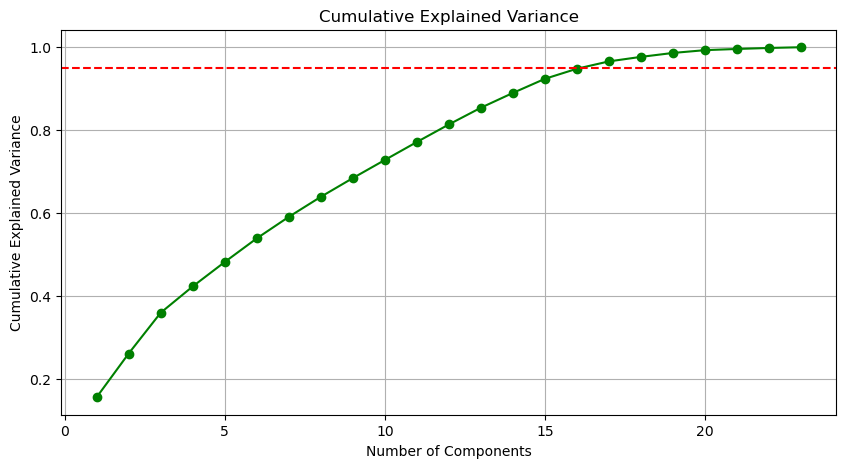

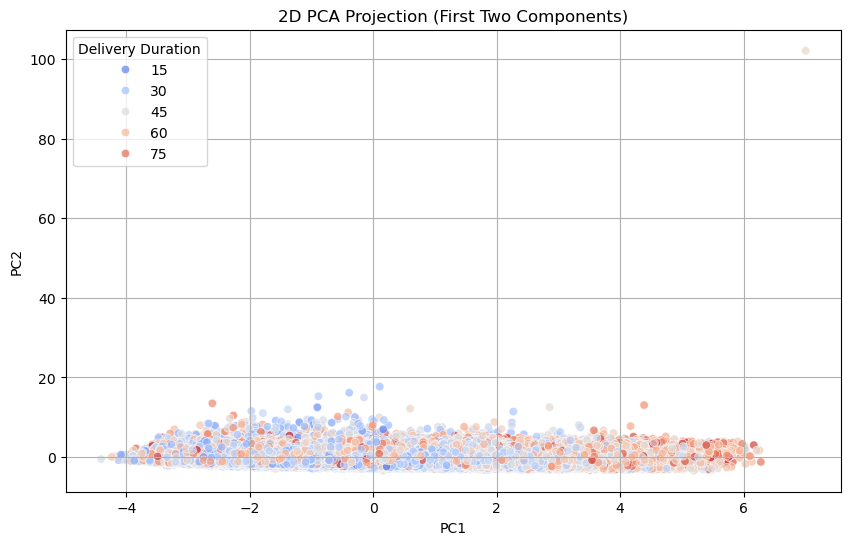

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize features
X = df_v1_cleaned.drop('delivery_duration', axis=1)
y = df_v1_cleaned['delivery_duration']
X_scaled = StandardScaler().fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
explained_var = pca.explained_variance_ratio_
cumulative_var = explained_var.cumsum()

# Plot 1: Scree Plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Plot 2: Cumulative Explained Variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_var)+1), cumulative_var, marker='o', color='green')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Plot 3: 2D PCA Projection
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='coolwarm', alpha=0.7)
plt.title('2D PCA Projection (First Two Components)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Delivery Duration', loc='best')
plt.grid(True)
plt.show()